In [1]:
path = "./data_intersec/"

### Imports

In [2]:
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
from IPython.display import clear_output
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter
import scipy.signal as sps
import matplotlib.ticker as ticker
import pandas as pd
from scipy import stats
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.linear_model import RidgeClassifier
import numpy as np
from matplotlib.axis import Axis
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.integrate import solve_ivp
from tqdm import tqdm

%matplotlib inline

### Data loading and helper functions

In [3]:
n_signals = 9

ca1 = []
ca3 = []
for i in range(n_signals):
    ca1.append(np.load(path + "ca1_3_" + str(i) + ".npy"))
    ca3.append(np.load(path + "ca3_3_" + str(i) + ".npy"))

ca1 = np.array(ca1)
ca3 = np.array(ca3)

In [4]:
def gausFilter(signal, sigma = 35):
    min1 = np.min(signal)
    gf = gaussian_filter(signal, sigma)
    min2 = np.min(gf)
    return gf*min1/min2

In [5]:
for i in range(n_signals):
    ca1[i] = gausFilter(ca1[i])
    ca3[i] = gausFilter(ca3[i])

In [6]:
train_ca1 = ca1[1:].copy()
test_ca1 = ca1[0].copy()

train_ca3 = ca3[1:].copy()
test_ca3 = ca3[0].copy()

for i in range(len(train_ca1)):
    train_ca1[i] = (train_ca1[i] - train_ca1[i].mean()) / train_ca1[i].std()
    train_ca3[i] = (train_ca3[i] - train_ca3[i].mean()) / train_ca3[i].std()

# for i in range(len(test_ca1)):
#     test_ca1[i] = (test_ca1[i] - test_ca1[i].mean()) / test_ca1[i].std()
#     test_ca3[i] = (test_ca3[i] - test_ca3[i].mean()) / test_ca3[i].std()


test_ca1 = (test_ca1 - test_ca1.mean()) / test_ca1.std()
test_ca3 = (test_ca3 - test_ca3.mean()) / test_ca3.std()

In [7]:
MAX = max(train_ca3.max(), train_ca1.max())
MIN = max(train_ca3.min(), train_ca1.min())


In [8]:
def create_inout_sequences(input_data, target_data, tw, hop, amp, batch_size=64):
    inout_seq = []
    L = len(input_data)
    for i in range(0, L - max(batch_size,tw), hop):
        train_seq = input_data[i:i+tw]
        train_label = target_data[i:i+tw]
        inout_seq.append((train_seq, train_label))
    return inout_seq

In [9]:
train_window = 1000
hop_len = train_window // 2
train_inout_seq = []
for i in range(len(train_ca1)):
    train_inout_seq += create_inout_sequences(train_ca3[i], train_ca1[i], train_window, hop_len, 1.)

#test_inout_seq1 = create_inout_sequences(test_ca3[0], test_ca1[0], train_window, hop_len)
#test_inout_seq2 = create_inout_sequences(test_ca3[1], test_ca1[1], train_window, hop_len)

#test_inout_seq = test_inout_seq1 + test_inout_seq2

test_inout_seq = create_inout_sequences(test_ca3, test_ca1, train_window, hop_len, 1.)

In [10]:
def GetWeitsWin(concat_len):
    y_data = stats.norm.pdf(np.arange(0, concat_len, 1), 0, concat_len/5)
    y_data2 = stats.norm.pdf(np.arange(-concat_len, 0, 1), 0, concat_len/5)

    weights = np.concatenate((np.expand_dims(y_data, axis=1), np.expand_dims(y_data2, axis=1)), axis=1)
    weights = weights / np.expand_dims(weights.sum(axis=1), axis=1)
    return weights

In [11]:
def SmoothSignal(signal, win, hop):
    #now support only win // hop = 2
    sm_signal = []
    weights = GetWeitsWin(hop)
    sm_signal.append(signal[:hop])
    for w in range(0, len(signal) - win, win):
        left_signal = signal[w+(win-hop):w+win] * weights[:, 0]
        right_signal = signal[w+win:w+win+hop] * weights[:, 1]

        sm_signal.append(left_signal + right_signal)
    #sm_signal.append(signal[w+win+hop: w+2*win])

    return np.array(sm_signal).flatten()

In [12]:
def GetPredSignal(model_lstm, win, hop, test_dataloader):
    preds = []
    model_lstm.eval()
    for idx, (x, y) in enumerate(tqdm(test_dataloader)):


            x = x[..., None].to('cuda')

            out = model_lstm(x)


            preds.append(out.detach().cpu().numpy().flatten())
    preds = np.array(preds).flatten()
    sm_preds = SmoothSignal(preds, win, hop)
    return sm_preds

In [13]:
def ToVector(point):
    idx = int((point- MIN)/(MAX - MIN) * 512)
    if idx >=512:
        idx = 511
    res = np.zeros(512)
    res[idx] = 1
    return res

def ToPoint(point):
    return MIN + (MAX - MIN) / 512 * point

### Reservoir func

In [19]:
def ReservoirComputings(inout_seq, test, a=0.5, size=400, spectral_radius=0.001, reg = 1e-8, trainLen=1000, initLen=100):



    # generate the ESN reservoir
    inSize = outSize = 512
    resSize = size

    np.random.seed(42)
    Win = (np.random.rand(resSize,1+inSize) - 0.5) * 1024
    W = (np.random.rand(resSize,resSize) - 0.5) * 1024
    for i in range(resSize):
        W[i][i] = 0
    # normalizing and setting spectral radius (correct, slow):
    #print('Computing spectral radius...')
    #rhoW = max(abs(linalg.eig(W)[0]))
    print('done.')
    #W *= spectral_radius / rhoW
    
    #print("rhoW", rhoW)
       

    # allocated memory for the design (collected states) matrix
    
    X = []
    
    Yt = []
    
    x_init = (np.random.rand(resSize,1) - 0.5) * 1024
    
    print("x_init", x_init)
    
    for i, val in enumerate(tqdm(train_inout_seq)):
        
        
        x = x_init
         
        for t in range(trainLen):
            u = ToVector(val[0][t])
            inp = np.concatenate(([1],u))
            #print("Win part", np.dot(Win, inp).shape)
            #print("W part", np.dot( W, x ).shape)
            x = (1-a)*x + a*np.tanh(np.dot(Win, inp)[..., None] + np.dot( W, x ) )

            if t >= initLen:
                #print(x.shape)
                #np.concatenate(([1],u,x[:, 0]))
                X.append(np.concatenate(([1],u,x[:, 0])))
                Yt.append(ToVector(val[1][t]))
                

        
                
        
        # train the output by ridge regression
          # regularization coefficient
        # direct equations from texts:
        #X_T = X.T
        #Wout = np.dot( np.dot(Yt,X_T), linalg.inv( np.dot(X,X_T) + \
        #    reg*np.eye(1+inSize+resSize) ) )
        # using scipy.linalg.solve:
        
    
    X = np.array(X)
    Yt = np.array(Yt)
    
#     print(X.shape)
#     print(Yt.shape)
    
    
    clf = RidgeClassifier(alpha=reg)
    clf.fit(X, Yt)
    
    #x = np.zeros((resSize,1))
    
    cf_max = clf.coef_.max()
    cf_min = clf.coef_.min()
    
    Wout = np.round(((clf.coef_- cf_min)/(cf_max - cf_min) * 1024) - 512)
    
    Win = np.round(Win)
    W = np.round(W)
    
    print("some x", x)
    print("W", W)
    print("Win", Win)
    print("Wout", Wout)
    
    Ans = []
    x = x_init
    for t in range(len(test)):
        u = ToVector(test[t])
        inp = np.concatenate(([1],u))
        Weights = np.dot(Win, inp)[..., None] + np.dot( W, x )
        new_reservoir = (Weights > 1) + -1*(Weights < -1)
        x = np.round((1-a)*x + a*new_reservoir)
        feat = np.concatenate(([1],u,x[:, 0]))[None, ...]
        #print(feat.shape)
        #y = clf.predict(feat)
        Ans.append(np.argmax(Wout @ feat.T))

    print("some x final", x)    
    
    return np.array(Ans), clf
    

### Plotting

In [20]:
ans, clf = ReservoirComputings(train_inout_seq, test_ca3, a=0.5, size=400, spectral_radius=0.001, reg = 1e-8, trainLen=1000, initLen=100)

done.
x_init [[ 292.49845904]
 [-497.46119353]
 [ 344.27228854]
 [-483.89165292]
 [ 288.92042692]
 [-443.03094832]
 [ 509.77997147]
 [ 421.59566536]
 [ 478.25242034]
 [-156.82375755]
 [-113.03871388]
 [-163.72072123]
 [  30.7156745 ]
 [ 460.00227251]
 [ 327.57282356]
 [  22.80657988]
 [ 445.50107301]
 [ 138.21199583]
 [-256.90078932]
 [ 324.14051301]
 [  83.83796683]
 [ 117.41217399]
 [ 247.80174462]
 [ -38.58631063]
 [ 375.14841568]
 [-175.9811412 ]
 [-446.15983195]
 [-415.9213299 ]
 [ 201.84096866]
 [-186.22630179]
 [ 254.64087297]
 [-494.33439603]
 [-412.90463534]
 [-328.78102033]
 [-321.65221339]
 [-187.11171138]
 [-469.46121033]
 [ 117.41839066]
 [-379.56161596]
 [-362.51880943]
 [-429.71809179]
 [-341.89908958]
 [-401.73127924]
 [  90.06552161]
 [-113.23907363]
 [-357.01492643]
 [-103.73084682]
 [-179.73084473]
 [ 278.93893774]
 [ 337.4844641 ]
 [-498.80001577]
 [  68.74049099]
 [-345.77185857]
 [ 322.63575942]
 [ 274.87032598]
 [-384.58479426]
 [-198.29971215]
 [ 101.13260389]
 

100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:16<00:00, 10.43it/s]


some x [[ 6.24999999e-01]
 [ 9.99038815e-01]
 [ 9.68261838e-01]
 [ 7.32469541e-03]
 [-7.49023437e-01]
 [ 9.99999999e-01]
 [ 9.83520508e-01]
 [-9.99999523e-01]
 [ 5.07799625e-01]
 [ 1.17187560e-01]
 [-9.99996185e-01]
 [ 8.78425584e-01]
 [-4.38476566e-01]
 [ 9.68872070e-01]
 [ 9.99999999e-01]
 [-9.96580126e-01]
 [-4.76549147e-01]
 [ 9.92652416e-01]
 [ 9.99999046e-01]
 [ 9.99999997e-01]
 [ 8.90609738e-01]
 [-6.86523438e-01]
 [ 2.50000716e-01]
 [ 5.54680824e-01]
 [ 5.94051480e-01]
 [ 9.99996304e-01]
 [ 5.62498093e-01]
 [-9.99999524e-01]
 [-9.99999765e-01]
 [-9.36462402e-01]
 [-6.25000014e-01]
 [ 9.99946125e-01]
 [-5.21545158e-08]
 [ 8.75001906e-01]
 [ 9.98535156e-01]
 [ 8.72817989e-01]
 [-8.82799148e-01]
 [-7.53907204e-01]
 [ 1.24757290e-01]
 [ 7.57026311e-03]
 [ 7.39842653e-06]
 [ 9.99999051e-01]
 [-8.82812500e-01]
 [-9.92186756e-01]
 [ 9.97070298e-01]
 [-8.75037669e-01]
 [-7.52197251e-01]
 [ 9.96550024e-01]
 [-5.00001042e-01]
 [-9.86326337e-01]
 [ 9.99999046e-01]
 [ 9.99038637e-01]
 [-9.

some x final [[ 2.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]
 [ 2.]
 [-0.]
 [-2.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 2.]
 [-0.]
 [ 0.]
 [-2.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-2.]
 [-0.]
 [ 2.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 2.]
 [ 0.]
 [-2.]
 [ 0.]
 [-0.]
 [-0.]
 [-0.]
 [ 2.]
 [-0.]
 [ 0.]
 [ 0.]
 [-0.]
 [-2.]
 [-0.]
 [ 0.]
 [-2.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 2.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]
 [-2.]
 [ 0.]
 [-2.]
 [ 0.]
 [-0.]
 [ 2.]
 [-2.]
 [ 0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-2.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 2.]
 [ 0.]
 [ 2.]
 [-2.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-2.]
 [-2.]
 [ 2.]
 [ 0.]
 [-2.]
 [-2.]
 [ 0.]
 [ 0.]
 [-2.]
 [-2.]
 [ 0.]
 [ 0.]
 [-0.]
 [-2.]
 [ 0.]
 [ 0.]
 [-2.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]


In [21]:
ans = np.array([ToPoint(val) for val in ans])

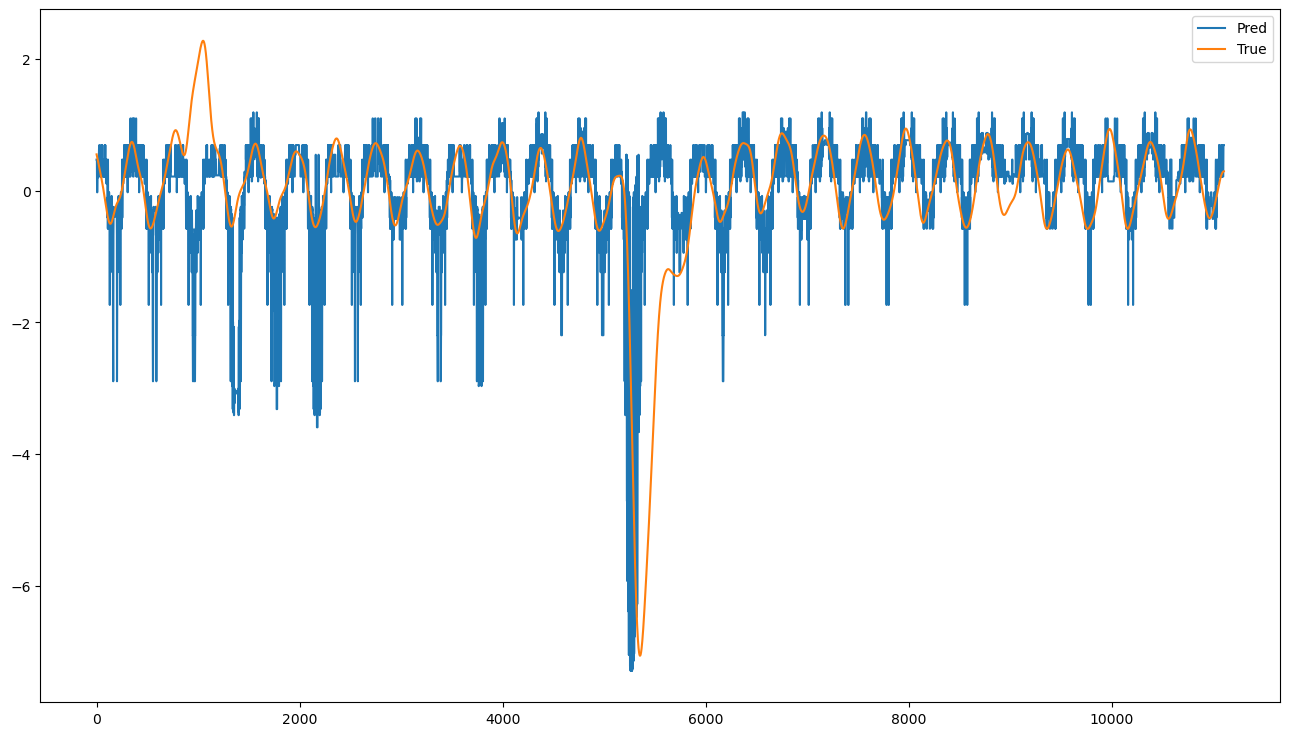

In [22]:
plt.figure(figsize=(16, 9))
plt.plot(ans[100:], label="Pred")
plt.plot(test_ca1[100:], label="True")
plt.legend()

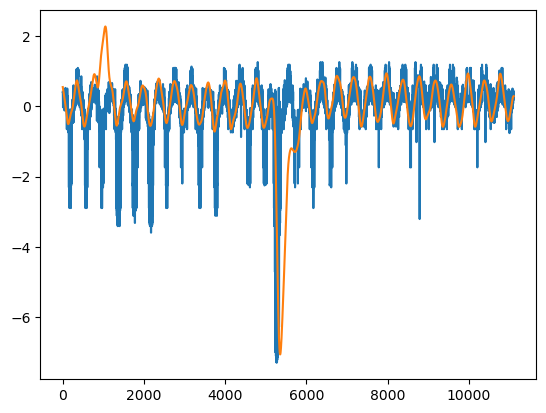

In [155]:
plt.figure(figsize=(16, 9))
plt.plot(ans[100:], label="Pred")
plt.plot(test_ca1[100:], label="True")
plt.legend()

### Drafts

In [158]:
cf_max = clf.coef_.max()
cf_min = clf.coef_.min()
Wout = np.round(((clf.coef_- cf_min)/(cf_max - cf_min) * 1024) - 512)

In [128]:
x = np.random.rand(913)[None, ...]
z = clf.predict(x)

In [129]:
z

array([29], dtype=int64)

In [130]:
x.shape

(1, 913)

In [133]:
np.argmax(clf.coef_ @ x.T)

29

In [145]:
clf.coef_.max()

1.9955238742613155

In [140]:
clf.coef_.shape

(512, 913)

In [107]:
ans.shape

(11202, 1)

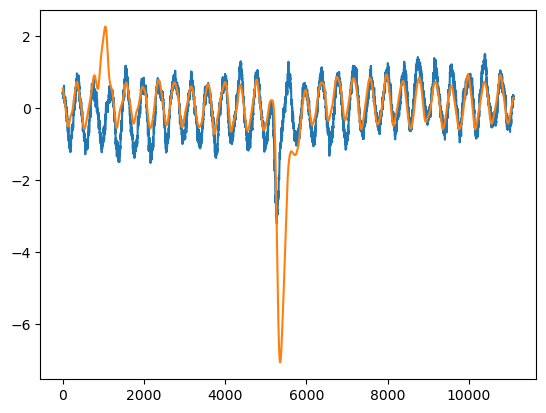

In [55]:
plt.plot(ans[100:])
plt.plot(test_ca1[100:])

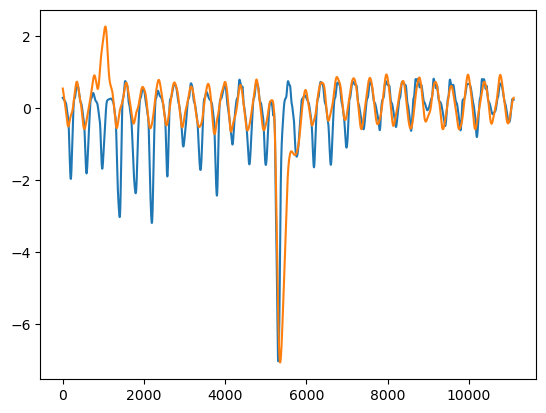

In [41]:
plt.plot(ans[100:])
plt.plot(test_ca1[100:])